<a href="https://colab.research.google.com/github/sdevries0/ISMI_group13/blob/main/neural_sde.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural SDE

This example constructs a neural SDE as a generative time series model.

An SDE is, of course, random: it defines some distribution. Each sample is a whole path. Thus in modern machine learning parlance, an SDE is a generative time series model. This means it can be trained as a GAN, for example. This does mean we need a discriminator that consumes a path as an input; we use a CDE.

Training an SDE as a GAN is precisely what this example does. Doing so will reproduce the following toy example, which is trained on irregularly-sampled time series:

![ou](../imgs/neural_sde.png)

**References:**

Training SDEs as GANs:
```bibtex
@inproceedings{kidger2021sde1,
    title={{N}eural {SDE}s as {I}nfinite-{D}imensional {GAN}s},
    author={Kidger, Patrick and Foster, James and Li, Xuechen and Lyons, Terry J},
    booktitle = {Proceedings of the 38th International Conference on Machine Learning},
    pages = {5453--5463},
    year = {2021},
    volume = {139},
    series = {Proceedings of Machine Learning Research},
    publisher = {PMLR},
}
```

Improved training techniques:
```bibtex
@incollection{kidger2021sde2,
    title={{E}fficient and {A}ccurate {G}radients for {N}eural {SDE}s},
    author={Kidger, Patrick and Foster, James and Li, Xuechen and Lyons, Terry},
    booktitle = {Advances in Neural Information Processing Systems 34},
    year = {2021},
    publisher = {Curran Associates, Inc.},
}
```

This example is available as a Jupyter notebook [here](https://github.com/patrick-kidger/diffrax/blob/main/examples/neural_sde.ipynb).

!!! warning

    This example will need a GPU to run efficiently.

!!! danger "Advanced example"

    This is a pretty advanced example.

In [1]:
!pip install jax==0.3.15
!pip install jaxlib==0.3.15
!pip install diffrax
!pip install optax

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 14.3 MB/s 
  Created wheel for jax: filename=jax-0.3.15-py3-none-any.whl size=1201921 sha256=dbd91332f1c394b78805571a6363bbb1eafa658b4eb1b853d83752dcc538e20c
  Stored in directory: /root/.cache/pip/wheels/7b/36/dc/90243142efbc28986784e072b123d4e674dc79edd013ce665b
Successfully built jax
  Attempting uninstall: jax
    Found existing installation: jax 0.3.23
    Uninstalling jax-0.3.23:
      Successfully uninstalled jax-0.3.23
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 72.0 MB 115 kB/s 
  Attempting uninstall: jaxlib
    Found existing installation: jaxlib 0.3.22+cuda11.cudnn805
    Uninstalling jaxlib-0.3.22+cuda11.cudnn805:
      Successfully uninstalled jaxlib-0.3.22+cuda11.cudnn805
Looking in indexes: https://pypi.org/simple, https://us-python.

In [2]:
from typing import Union

import jax
import jaxlib
import diffrax
import equinox as eqx  # https://github.com/patrick-kidger/equinox
import jax
import numpy as np
import jax.nn as jnn
import jax.numpy as jnp
import jax.random as jrandom
import matplotlib.pyplot as plt
import optax  # https://github.com/deepmind/optax

LipSwish activation functions are a good choice for the discriminator of an SDE-GAN. (Their use here was introduced in the second reference above.)
For simplicity we will actually use LipSwish activations everywhere, even in the generator.

In [3]:
# Define control path with multiple different functions. t is added to the resulting array. 
class MultiControlPath(diffrax.AbstractPath):

    C : int
    phase: float
    frequency: float

    def __init__(self, phase, frequency, C = 2):
      self.C = C
      self.phase = phase
      self.frequency = frequency

    def evaluate(self, t0, t1=None, left=True):
      del left
      if t1 is not None:
        return self.evaluate(t1) - self.evaluate(t0)
      #Evaluate t0 and t1 for each sinoid control 
      controls_at_t = jnp.array([jnp.sin(self.phase[i] + self.frequency[i] * t0) for i in range(self.C)])
      return jnp.append(t0, controls_at_t)

In [4]:
def lipswish(x):
    return 0.909 * jnn.silu(x)

r = lambda x: jnp.tanh(x)

Now set up the vector fields appearing on the right hand side of each differential equation.

In [5]:
#RNN that models the states of neurons given input. Used as state equation for an NCDE for an NSDE
class NeuralSystem(eqx.Module):
    
    J: float
    B: float
    b: float
    tau: float
    N: int
    C: int
    
    def __init__(self, key, N, C, tau):
        super().__init__()
        keys = jrandom.split(key, 3)
        self.J = jrandom.normal(keys[0], shape=(N,N))
        self.B = jrandom.normal(keys[1], shape=(N,C))
        self.b = jrandom.normal(keys[2], shape=(N,))
        self.tau = tau
        self.N = N
        self.C = C

    def __call__(self, t, x, args):
      #Returns tau*x' = -x + Jr(x) + Bu + b + sigma(x,t)*dw
      return jnp.concatenate(((-x+self.J@r(x) + self.b).reshape(self.N,1), self.B), axis = 1)

class NeuralNoise(eqx.Module):
    sigma: float

    def __init__(self, key, N, S):
      self.sigma = jrandom.normal(key, shape=(N,S))

    def __call__(self, t, x ,args):
      return self.sigma

In [6]:
class VectorField(eqx.Module):
    scale: Union[int, jnp.ndarray]
    mlp: eqx.nn.MLP
    hidden_size: int

    def __init__(self, hidden_size, width_size, depth, scale, *, key, **kwargs):
        super().__init__(**kwargs)
        scale_key, mlp_key = jrandom.split(key)
        if scale:
            self.scale = jrandom.uniform(
                scale_key, (hidden_size), minval=0.9, maxval=1.1
            )
        else:
            self.scale = 1
        self.mlp = eqx.nn.MLP(
            in_size=hidden_size,
            out_size=hidden_size,
            width_size=width_size,
            depth=depth,
            activation=lipswish,
            final_activation=jnn.tanh,
            key=mlp_key,
        )
        self.hidden_size = hidden_size

    def __call__(self, t, y, args):
        return self.scale * self.mlp(y)


class ControlledVectorField(eqx.Module):
    scale: Union[int, jnp.ndarray]
    mlp: eqx.nn.MLP
    control_size: int
    hidden_size: int

    def __init__(
        self, control_size, hidden_size, width_size, depth, scale, *, key, **kwargs
    ):
        super().__init__(**kwargs)
        scale_key, mlp_key = jrandom.split(key)
        if scale:
            self.scale = jrandom.uniform(
                scale_key, (hidden_size, control_size), minval=0.9, maxval=1.1
            )
        else:
            self.scale = 1
        self.mlp = eqx.nn.MLP(
            in_size=hidden_size,
            out_size=hidden_size * control_size,
            width_size=width_size,
            depth=depth,
            activation=lipswish,
            final_activation=jnn.tanh,
            key=mlp_key,
        )
        self.control_size = control_size
        self.hidden_size = hidden_size

    def __call__(self, t, y, args):
        return self.scale * self.mlp(y).reshape(
            self.hidden_size, self.control_size
        )

Now set up the neural SDE (the generator) and the neural CDE (the discriminator).

- Note the use of very large step sizes. By using a large step size we essentially "bake in" the discretisation. This is quite a standard thing to do to decrease computational costs, when the vector field is a pure neural network. (You can reduce the step size here if you want to -- which will increase the computational cost, of course.)

- Note the `clip_weights` method on the CDE -- this is part of imposing the Lipschitz condition on the discriminator of a Wasserstein GAN.
(The other thing doing this is the use of those LipSwish activation functions we saw earlier)

In [7]:
class NeuralSDE(eqx.Module):
    initial: eqx.nn.MLP
    vf: NeuralSystem  # drift
    cvf: NeuralNoise  # diffusion
    readout: eqx.nn.Linear
    initial_noise_size: int
    noise_size: int
    C: int

    def __init__(
        self,
        M,
        C,
        initial_noise_size,
        noise_size,
        N,
        width_size,
        depth,
        *,
        key,
        **kwargs,
    ):
        super().__init__(**kwargs)
        initial_key, vf_key, cvf_key, readout_key = jrandom.split(key, 4)

        self.initial = eqx.nn.MLP(
            initial_noise_size, N, width_size, depth, key=initial_key
        )
        # self.vf = ControlledVectorField(C+1, N, width_size, depth, scale=True, key=vf_key)
        self.vf = NeuralSystem(vf_key, N, C, 1.0)
        self.cvf = NeuralNoise(cvf_key, N, noise_size)
        # self.cvf = ControlledVectorField(noise_size, N, width_size, depth, scale=True, key=cvf_key)
        self.readout = eqx.nn.Linear(N, M, key=readout_key)

        self.initial_noise_size = initial_noise_size
        self.noise_size = noise_size
        self.C = C

    def __call__(self, ts, key, phase, frequency):
        t0 = ts[0]
        t1 = ts[-1]
        dt0 = 0.1
        init_key, bm_key = jrandom.split(key, 2)
        init = jrandom.normal(init_key, (self.initial_noise_size,))
        control = MultiControlPath(phase, frequency, self.C)
        noise = diffrax.VirtualBrownianTree(
            t0=t0, t1=t1, tol=dt0 / 2, shape=(self.noise_size,), key=bm_key
        )
        vf = diffrax.ControlTerm(self.vf, control).to_ode()  # Drift term
        cvf = diffrax.ControlTerm(self.cvf, noise)  # Diffusion term
        terms = diffrax.MultiTerm(vf, cvf)
        # ReversibleHeun is a cheap choice of SDE solver. We could also use Euler etc.
        solver = diffrax.Euler()
        y0 = self.initial(init)
        saveat = diffrax.SaveAt(ts=ts)
        # We happen to know from our dataset that we're not going to take many steps.
        # Specifying a smallest-possible upper bound speeds things up.
        sol = diffrax.diffeqsolve(
            terms, solver, t0, t1, dt0, y0, saveat=saveat, max_steps=256, stepsize_controller=diffrax.ConstantStepSize(),
        )
        return jax.vmap(self.readout)(sol.ys)


class NeuralCDE(eqx.Module):
    initial: eqx.nn.MLP
    vf: VectorField
    cvf: ControlledVectorField
    readout: eqx.nn.Linear

    def __init__(self, M, N, width_size, depth, *, key, **kwargs):
        super().__init__(**kwargs)
        initial_key, vf_key, cvf_key, readout_key = jrandom.split(key, 4)

        self.initial = eqx.nn.MLP(
            M, N, width_size, depth, key=initial_key
        )
        self.vf = VectorField(N, width_size, depth, scale=False, key=vf_key)
        self.cvf = ControlledVectorField(
            M, N, width_size, depth, scale=False, key=cvf_key
        )
        self.readout = eqx.nn.Linear(N, 1, key=readout_key)

    def __call__(self, ts, ys):
        # Interpolate data into a continuous path.
        ys = diffrax.linear_interpolation(
            ts, ys, replace_nans_at_start=0.0, fill_forward_nans_at_end=True
        )
        init = ys[0]
        control = diffrax.LinearInterpolation(ts, ys)
        vf = diffrax.ODETerm(self.vf)
        cvf = diffrax.ControlTerm(self.cvf, control).to_ode()
        terms = diffrax.MultiTerm(vf, cvf)
        solver = diffrax.ReversibleHeun()
        t0 = ts[0]
        t1 = ts[-1]
        dt0 = 0.1
        y0 = self.initial(init)
        # Have the discriminator produce an output at both `t0` *and* `t1`.
        # The output at `t0` has only seen the initial point of a sample. This gives
        # additional supervision to the distribution learnt for the initial condition.
        # The output at `t1` has seen the entire path of a sample. This is needed to
        # actually learn the evolving trajectory.
        saveat = diffrax.SaveAt(t0=True, t1=True)
        sol = diffrax.diffeqsolve(
            terms, solver, t0, t1, dt0, y0, saveat=saveat, max_steps=256
        )
        return jax.vmap(self.readout)(sol.ys)

    @eqx.filter_jit
    def clip_weights(self):
        leaves, treedef = jax.tree_util.tree_flatten(
            self, is_leaf=lambda x: isinstance(x, eqx.nn.Linear)
        )
        new_leaves = []
        for leaf in leaves:
            if isinstance(leaf, eqx.nn.Linear):
                lim = 1 / leaf.out_features
                leaf = eqx.tree_at(
                    lambda x: x.weight, leaf, leaf.weight.clip(-lim, lim)
                )
            new_leaves.append(leaf)
        return jax.tree_util.tree_unflatten(treedef, new_leaves)

Next, the dataset. This follows the trajectories you can see in the picture above. (Namely positive drift with mean-reversion and time-dependent diffusion.)

In [8]:
# @jax.jit
# @jax.vmap
def get_data(key, N, C, S, J, B, b, process_noise):
    keys = jrandom.split(key, 4)
    bm_key, y0_key, drop_key, ph_key, fr_key = jrandom.split(key, 5)

    frequency = jrandom.uniform(fr_key, shape=(C,), minval = 0.0, maxval = 1.0)
    phase = jrandom.normal(ph_key, shape=(C,))
    control = MultiControlPath(phase, frequency, C)
    
    def drift(t, x, args):
        return jnp.concatenate(((-x+J@r(x) + b).reshape(N,1), B), axis = 1)

    def diffusion(t, y, args):
        return process_noise

    bm = diffrax.UnsafeBrownianPath(shape=(S,), key=bm_key)
    drift = diffrax.ControlTerm(drift, control).to_ode()
    diffusion = diffrax.ControlTerm(diffusion, bm)
    terms = diffrax.MultiTerm(drift, diffusion)
    solver = diffrax.Euler()
    dt0 = 0.1
    t0 = 0
    t1 = 8*jnp.pi
    t_size = 100
    y0 = jrandom.uniform(y0_key, (N,), minval=-1, maxval=1)
    ts = jnp.linspace(t0, t1, t_size)
    saveat = diffrax.SaveAt(ts=ts)
    sol = diffrax.diffeqsolve(
        terms, solver, t0, t1, dt0, y0, saveat=saveat, adjoint=diffrax.NoAdjoint()
    )

    # Make the data irregularly sampled
    # to_drop = jrandom.bernoulli(drop_key, 0.3, (t_size, 1))
    # ys = jnp.where(to_drop, jnp.nan, sol.ys)

    return ts, sol.ys, phase, frequency


def dataloader(arrays, batch_size, loop, *, key):
    dataset_size = arrays[0].shape[0]
    assert all(array.shape[0] == dataset_size for array in arrays)
    indices = jnp.arange(dataset_size)
    while True:
        perm = jrandom.permutation(key, indices)
        key = jrandom.split(key, 1)[0]
        start = 0
        end = batch_size
        while end < dataset_size:
            batch_perm = perm[start:end]
            yield tuple(array[batch_perm] for array in arrays)
            start = end
            end = start + batch_size
        if not loop:
            break

Now the usual training step for GAN training.

There is one neural-SDE-specific trick here: we increase the update size (i.e. the learning rate) for those parameters describing (and discriminating) the initial condition of the SDE. Otherwise the model tends to focus just on fitting just the rest of the data (i.e. the random evolution over time).

In [9]:
@eqx.filter_jit
def loss(generator, discriminator, ts_i, ys_i, key, phase, frequency, step=0):
    batch_size, _ = ts_i.shape
    key = jrandom.fold_in(key, step)
    key = jrandom.split(key, batch_size)
    fake_ys_i = jax.vmap(generator)(ts_i, key, phase, frequency)
    real_score = jax.vmap(discriminator)(ts_i, ys_i)
    fake_score = jax.vmap(discriminator)(ts_i, fake_ys_i)
    return jnp.mean(real_score - fake_score)


@eqx.filter_grad
def grad_loss(g_d, ts_i, ys_i, key, phase, frequency, step):
    generator, discriminator = g_d
    return loss(generator, discriminator, ts_i, ys_i, key, phase, frequency, step)


def increase_update_initial(updates):
    get_initial_leaves = lambda u: jax.tree_util.tree_leaves(u.initial)
    return eqx.tree_at(get_initial_leaves, updates, replace_fn=lambda x: x * 10)


@eqx.filter_jit
def make_step(
    generator,
    discriminator,
    g_opt_state,
    d_opt_state,
    g_optim,
    d_optim,
    ts_i,
    ys_i,
    key,
    phase,
    frequency,
    step,
):
    g_grad, d_grad = grad_loss((generator, discriminator), ts_i, ys_i, key, phase, frequency, step)
    g_updates, g_opt_state = g_optim.update(g_grad, g_opt_state)
    d_updates, d_opt_state = d_optim.update(d_grad, d_opt_state)
    g_updates = increase_update_initial(g_updates)
    d_updates = increase_update_initial(d_updates)
    generator = eqx.apply_updates(generator, g_updates)
    discriminator = eqx.apply_updates(discriminator, d_updates)
    discriminator = discriminator.clip_weights()
    return generator, discriminator, g_opt_state, d_opt_state

This is our main entry point. Try running `main()`.

In [10]:
def find_order(Ws, W):
  orders = np.zeros(W.shape, dtype=int)
  for i in range(orders.shape[0]):
    original = jnp.argsort(jnp.abs(Ws[-1][i]))
    target = jnp.argsort(jnp.abs(W[i]))
    for j in range(orders.shape[1]):
      orders[i, original[j]] = target[j]

  final_order = np.zeros(W.shape[1], dtype=int)
  for j in range(orders.shape[1]):
    values, counts = np.unique(orders[:,j], return_counts=True)
    final_order[j] = values[jnp.argmax(counts)]
  return jnp.array(final_order)

def moving_avg(losses):
    mean_data = np.zeros(len(losses))
    mean_data[0] = losses[0]
    for i in range(1,len(losses)):
        mean_data[i] = (losses[i] * 0.01 ) + (losses[i-1] * 0.99 )
    return mean_data

def plot_figures(losses, Js, Bs, bs, Ws, J, B, b, W, pns, process_noise):
  # order = find_order(Ws,W)
  order = jnp.arange(0, J.shape[0], dtype=int)
  fig, axes = plt.subplots(2, 3, figsize=(14, 10))
  axes[0,0].plot(moving_avg(losses))
  axes[0,0].set_title("Loss")
  axes[0,0].set(xlabel="Epoch", ylabel="Log loss")
  axes[0,0].set_yscale('log')

  help_J = jnp.abs(jnp.array([j[order] for j in J[order]]))
  axes[0,1].plot([jnp.sum((help_J-jnp.abs(Js[i]))**2)/J.shape[0] for i in range(len(Js))])
  axes[0,1].set_title("Mean squared error from estimated J to true J")
  axes[0,1].set(xlabel="Epoch", ylabel="Mean squared error")

  help_B = jnp.abs(B[order])
  axes[1,0].plot([jnp.sum((jnp.abs(Bs[i])-help_B)**2)/B.shape[0] for i in range(len(Bs))])
  axes[1,0].set_title("Mean squared error from estimated B to true B")
  axes[1,0].set(xlabel="Epoch", ylabel="Mean squared error")

  help_b = jnp.abs(b[order])
  axes[1,1].plot([jnp.sum((jnp.abs(bs[i])-help_b)**2)/b.shape[0] for i in range(len(bs))])
  axes[1,1].set_title("Mean squared error from estimated b to true b")
  axes[1,1].set(xlabel="Epoch", ylabel="Mean squared error")

  # help_W = jnp.abs(W[:,order])
  # axes[0,2].plot([jnp.sum((jnp.abs(Ws[i])-help_W)**2)/W.shape[0] for i in range(len(Ws))])
  # axes[0,2].set_title("Mean squared error from estimated W to true W")
  # axes[0,2].set(xlabel="Epoch", ylabel="Mean squared error")

  help_pn = jnp.abs(process_noise[:,order])
  axes[1,2].plot([jnp.sum((jnp.abs(pns[i])-help_pn)**2)/(process_noise.shape[0]*process_noise.shape[1]) for i in range(len(pns))])
  axes[1,2].set_title("Mean squared error from estimated x0 to true x0")
  axes[1,2].set(xlabel="Epoch", ylabel="Mean squared error")
    
  # if J.shape[0] == 5:
  #   axes[0,0].set_ylim(bottom=0)
  #   axes[0,1].set_ylim(bottom=0, top=10)
  #   axes[0,1].set_xlim(left=0, right=20000)
  #   axes[1,0].set_ylim(bottom=0, top=10)
  #   axes[1,0].set_xlim(left=0, right=20000)
  #   axes[1,1].set_ylim(bottom=0, top=2)
  #   axes[1,1].set_xlim(left=0, right=20000)
  #   axes[0,2].set_ylim(bottom=0, top=10)
  #   axes[0,2].set_xlim(left=0, right=20000)
  # else:
  #   axes[0,0].set_ylim(bottom=0)
  #   axes[0,1].set_ylim(bottom=0, top=10)
  #   axes[0,1].set_xlim(left=0, right=20000)
  #   axes[1,0].set_ylim(bottom=0, top=10)
  #   axes[1,0].set_xlim(left=0, right=20000)
  #   axes[1,1].set_ylim(bottom=0, top=2)
  #   axes[1,1].set_xlim(left=0, right=20000)
  #   axes[0,2].set_ylim(bottom=0, top=10)
  #   axes[0,2].set_xlim(left=0, right=20000)

  plt.show()

  #RMSPROP instead of ADAM, no momentum, moving target

In [11]:
def main(
    initial_noise_size=2,
    C=2,
    N=3,
    noise_size=3,
    width_size=16,
    depth=1,
    generator_lr=2e-4,
    discriminator_lr=1e-3,
    batch_size=32,
    steps=20000,
    steps_per_print=500,
    dataset_size=128,
    seed=5678,
):

    key = jrandom.PRNGKey(seed)
    (
        variable_key,
        data_key,
        generator_key,
        discriminator_key,
        dataloader_key,
        train_key,
        evaluate_key,
        sample_key,
    ) = jrandom.split(key, 8)

    data_key = jrandom.split(data_key, dataset_size)
    J_key, B_key, b_key, pn_key = jrandom.split(variable_key, 4)

    p = 1.0
    J = jrandom.normal(J_key, shape=(N,N)) * jrandom.bernoulli(J_key, p=p, shape=(N,N)) 
    B = jrandom.normal(B_key, shape=(N,C)) * jrandom.bernoulli(B_key, p=p, shape=(N,C)) 
    b = jrandom.normal(b_key, shape=(N,))
    # process_noise = jrandom.normal(pn_key, shape=(N,noise_size))
    process_noise = 0.8*jnp.eye(N)
    # ts, ys, phases, frequencies = get_data(data_key, shapes)
    ts, ys, phases, frequencies = jax.vmap(get_data, in_axes=[0,None,None,None,None,None,None,None])(data_key, N, C, noise_size, J, B, b, process_noise)
    _, _, data_size = ys.shape

    generator = NeuralSDE(
        data_size,
        C,
        initial_noise_size,
        noise_size,
        N,
        width_size,
        depth,
        key=generator_key,
    )
    discriminator = NeuralCDE(
        data_size, N, width_size, depth, key=discriminator_key
    )

    g_optim = optax.rmsprop(generator_lr)
    d_optim = optax.rmsprop(-discriminator_lr)
    g_opt_state = g_optim.init(eqx.filter(generator, eqx.is_inexact_array))
    d_opt_state = d_optim.init(eqx.filter(discriminator, eqx.is_inexact_array))

    infinite_dataloader = dataloader(
        (ts, ys, phases, frequencies), batch_size, loop=True, key=dataloader_key
    )

    losses = []
    Js = [generator.vf.J]
    Bs = [generator.vf.B]
    bs = [generator.vf.b]
    pns = [generator.cvf.sigma]

    for step, (ts_i, ys_i, phase, frequency) in zip(range(steps), infinite_dataloader):
        step = jnp.asarray(step)
        generator, discriminator, g_opt_state, d_opt_state = make_step(
            generator,
            discriminator,
            g_opt_state,
            d_opt_state,
            g_optim,
            d_optim,
            ts_i,
            ys_i,
            key, 
            phase, 
            frequency,
            step,
        )
        
        total_score = 0
        num_batches = 0
        for ts_i, ys_i, phase, frequency in dataloader(
            (ts, ys, phases, frequencies), batch_size, loop=False, key=evaluate_key
        ):
            score = loss(generator, discriminator, ts_i, ys_i, sample_key, phase, frequency)
            total_score += score.item()
            num_batches += 1
        losses.append(total_score / num_batches)
        Js.append(generator.vf.J)
        Bs.append(generator.vf.B)
        bs.append(generator.vf.b)
        pns.append(generator.cvf.sigma)
        if (step % steps_per_print) == 0 or step == steps - 1:
            print(f"Step: {step}, Loss: {total_score / num_batches}")
        if (step % 2000) == 0 or step == steps - 1:
          # Plot samples
          fig, ax = plt.subplots()
          num_samples = min(50, dataset_size)
          ts_to_plot = ts[:num_samples]
          ys_to_plot = ys[:num_samples]
          phase_to_plot = phases[:num_samples]
          freq_to_plot = frequencies[:num_samples]


          def _interp(ti, yi):
              return diffrax.linear_interpolation(
                  ti, yi, replace_nans_at_start=0.0, fill_forward_nans_at_end=True
              )

          ys_to_plot = jax.vmap(_interp)(ts_to_plot, ys_to_plot)[..., 0]
          ys_sampled = jax.vmap(generator)(
              ts_to_plot, jrandom.split(sample_key, num_samples), phase_to_plot, freq_to_plot
          )[..., 0]
          kwargs = dict(label="Real")
          for ti, yi in zip(ts_to_plot, ys_to_plot):
              ax.plot(ti, yi, c="dodgerblue", linewidth=0.5, alpha=0.7, **kwargs)
              kwargs = {}
          kwargs = dict(label="Generated")
          for ti, yi in zip(ts_to_plot, ys_sampled):
              ax.plot(ti, yi, c="crimson", linewidth=0.5, alpha=0.7, **kwargs)
              kwargs = {}
          ax.set_title(f"{num_samples} samples from both real and generated distributions.")
          fig.legend()
          fig.tight_layout()
          # fig.savefig("neural_sde.png")
          plt.show()
    plot_figures(losses, Js, Bs, bs, [], J, B, b, [], pns, process_noise)
    # print("J",J, generator.vf.J)
    # print("B",B, generator.vf.B)
    # print("b",b, generator.vf.b)

/usr/local/lib/python3.7/dist-packages/diffrax/misc/ad.py:32: FutureWarning: jax.tree_leaves is deprecated, and will be removed in a future release. Use jax.tree_util.tree_leaves instead.
  if any(is_perturbed(xi) for xi in jax.tree_leaves(x)):
/usr/local/lib/python3.7/dist-packages/diffrax/integrate.py:83: FutureWarning: jax.tree_leaves is deprecated, and will be removed in a future release. Use jax.tree_util.tree_leaves instead.
  [ts, save_index] + jax.tree_leaves(ys),
/usr/local/lib/python3.7/dist-packages/diffrax/integrate.py:81: FutureWarning: jax.tree_leaves is deprecated, and will be removed in a future release. Use jax.tree_util.tree_leaves instead.
  lambda s: [s.ts, s.save_index] + jax.tree_leaves(s.ys),
/usr/local/lib/python3.7/dist-packages/diffrax/integrate.py:83: FutureWarning: jax.tree_leaves is deprecated, and will be removed in a future release. Use jax.tree_util.tree_leaves instead.
  [ts, save_index] + jax.tree_leaves(ys),
/usr/local/lib/python3.7/dist-packages/diff

Step: 0, Loss: 0.2950117190678914


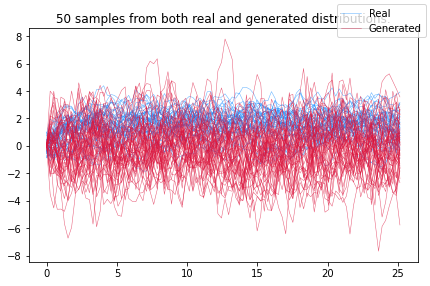

Step: 500, Loss: 23.949488321940105
Step: 1000, Loss: 26.781233469645183
Step: 1500, Loss: 41.21112187703451
Step: 2000, Loss: 41.72553380330404


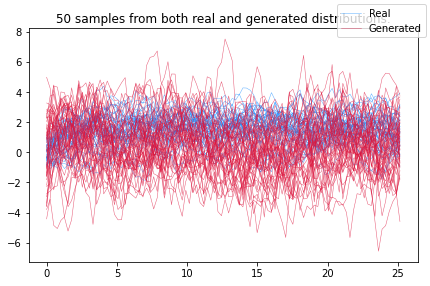

Step: 2500, Loss: 41.22459157307943
Step: 3000, Loss: 30.472003936767578
Step: 3500, Loss: 34.922743479410805
Step: 4000, Loss: 26.148170471191406


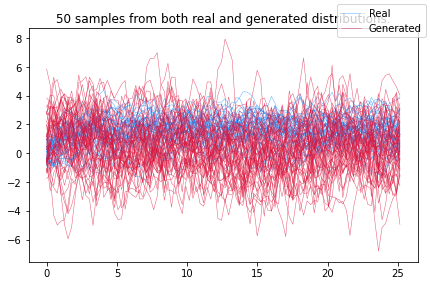

Step: 4500, Loss: 35.68224334716797
Step: 5000, Loss: 20.015158971150715
Step: 5500, Loss: 15.026249567667643
Step: 6000, Loss: 33.81241226196289


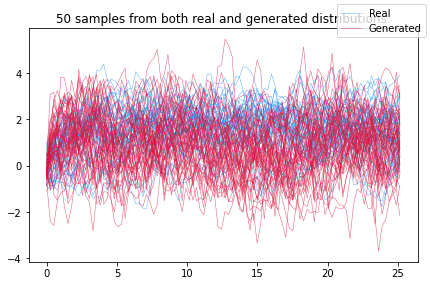

Step: 6500, Loss: 18.363803227742512
Step: 7000, Loss: 21.23722203572591
Step: 7500, Loss: 15.765754699707031
Step: 8000, Loss: 8.13910142580668


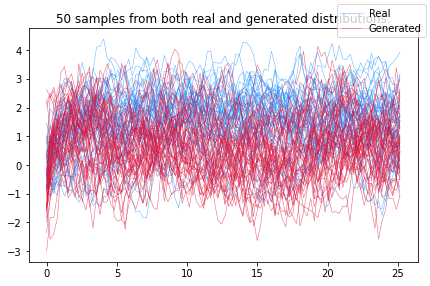

Step: 8500, Loss: -2.0793030659357705
Step: 9000, Loss: 19.45680554707845
Step: 9500, Loss: 16.55170440673828
Step: 10000, Loss: 16.715169270833332


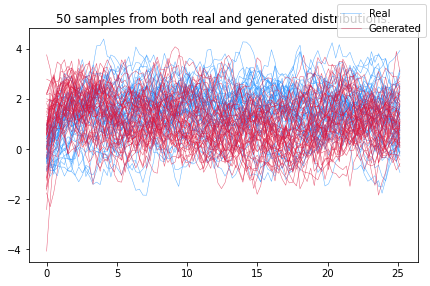

Step: 10500, Loss: 27.217592239379883
Step: 11000, Loss: 8.731771310170492
Step: 11500, Loss: 9.241005261739096
Step: 12000, Loss: 10.731618881225586


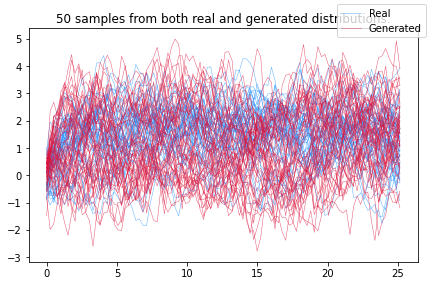

Step: 12500, Loss: 5.082363883654277
Step: 13000, Loss: 20.42515754699707
Step: 13500, Loss: 26.013275782267254
Step: 14000, Loss: 28.08390235900879


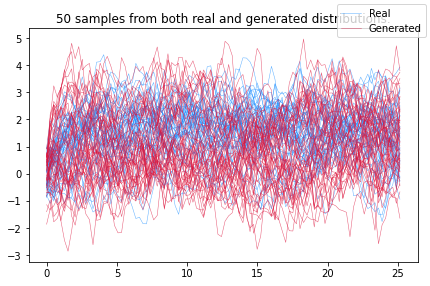

Step: 14500, Loss: 8.951615651448568
Step: 15000, Loss: 17.226584752400715
Step: 15500, Loss: 15.738245328267416
Step: 16000, Loss: 9.584032694498697


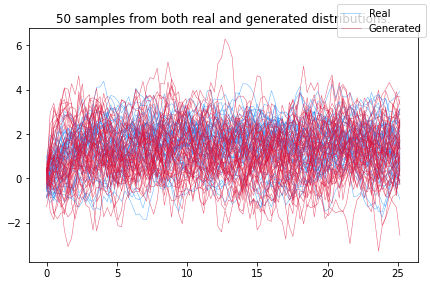

Step: 16500, Loss: 8.01542361577352
Step: 17000, Loss: 8.513331890106201
Step: 17500, Loss: 5.387767036755879
Step: 18000, Loss: 1.7008014917373657


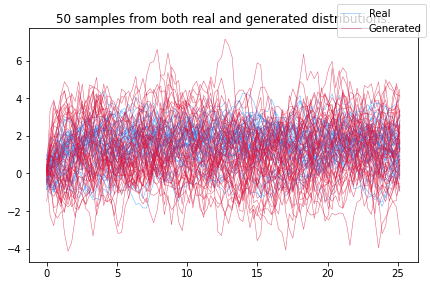

Step: 18500, Loss: 10.501877466837565
Step: 19000, Loss: 15.013687451680502
Step: 19500, Loss: 14.222308794657389
Step: 19999, Loss: 0.5233596165974935


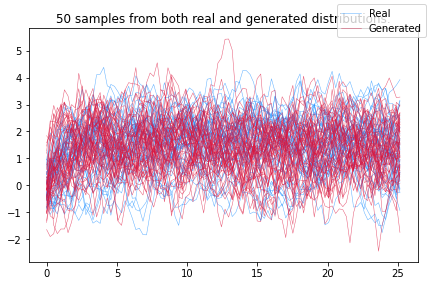

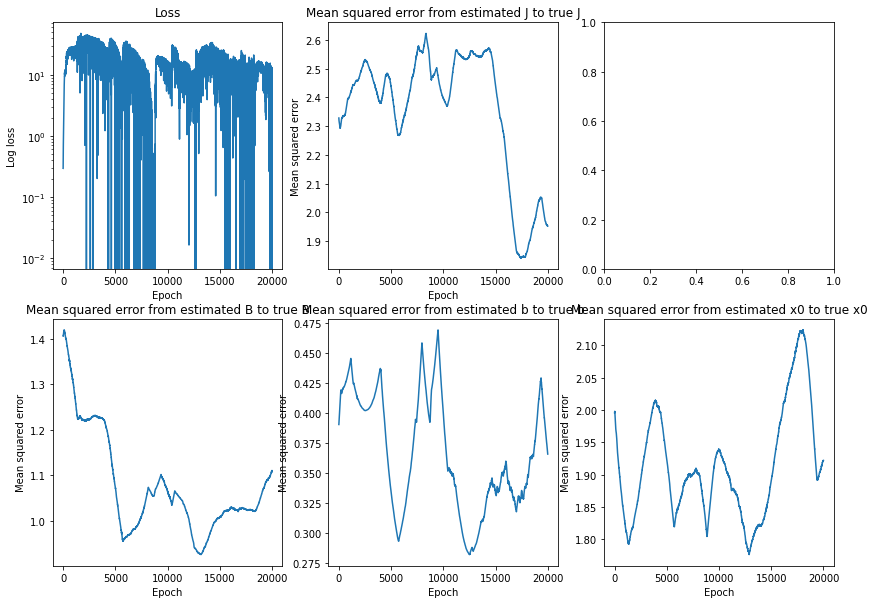

In [12]:
main()